# Visualization

In [ ]:
#|default_exp viz

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export 

from IPython.display import Image, display, HTML,SVG
import networkx as nx
from stringdale.core import jinja_render
import os
import shutil
import graphviz
import logging
from textwrap import wrap
logger = logging.getLogger(__name__)


## Rendering graphs with GraphViz

In [ ]:
#| export
from IPython.display import Markdown, display


In [ ]:
#| export
def is_ipython():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except ImportError:
        return False

def display_in_ipython(obj):
    if obj is None:
        return
    if is_ipython():
        display(obj)


In [ ]:
# Create example graph with node and edge properties
G = nx.DiGraph()

# Add nodes with properties
G.add_node('A', role='start', color='lightblue')
G.add_node('B', role='process', color='lightgreen') 
G.add_node('C', role='end', color='pink',nested_param = {'x':{'y':1}})

# Add edges with properties
G.add_edge('A', 'B', weight=5, label='step 1')
G.add_edge('B', 'C', weight=3, label='*')


# Draw the graph
# draw_nx(G,subgraph_colors={'green':['C','B']})


In [ ]:
#| export
def _attrs_to_str(attrs,drop_keys=None  ):
    if drop_keys is None:
        drop_keys = []
    return '\n'.join([f'{k}={v}' for k,v in attrs.items() if k not in drop_keys])


def wrap_text(text,width=None,**kwargs):
    if width is None or text is None:
        return text
    return '\n'.join(wrap(text,width=width,**kwargs))


def node_description(g,node,label_key=None,drop_keys=None,**kwargs):
    if drop_keys is None:
        drop_keys = []
    if label_key is not None:
        drop_keys.append(label_key)
    
    node_id = node
    node_data = g.nodes[node_id]
    
    node_data_str = _attrs_to_str(node_data,drop_keys=drop_keys)

    if label_key is None:
        node_str = f'{node_id}\n{node_data_str}'
    else:
        node_label = node_data[label_key]
        node_str = f'{node_id}({node_label})\n{node_data_str}'
    return wrap_text(node_str,**kwargs)

def edge_description(g,edge,drop_keys=None,**kwargs):
    edge_id = edge
    edge_data = g.edges[edge_id]
    edge_data_str = _attrs_to_str(edge_data,drop_keys=drop_keys)
    return wrap_text(edge_data_str,**kwargs)


def graph_to_graphviz_spec(g,label_key=None,drop_keys=None,**kwargs):
    node_kwargs = [{
        'name':node, 'label':node_description(g,node,label_key=label_key,drop_keys=drop_keys,**kwargs)
    } for node in g.nodes]
    edge_kwargs = [{
        'tail_name':edge[0], 'head_name':edge[1], 'label':edge_description(g,edge,drop_keys=drop_keys,**kwargs)
    } for edge in g.edges]

    return node_kwargs, edge_kwargs

In [ ]:
graph_to_graphviz_spec(G)

([{'name': 'A', 'label': 'A\nrole=start\ncolor=lightblue'},
  {'name': 'B', 'label': 'B\nrole=process\ncolor=lightgreen'},
  {'name': 'C',
   'label': "C\nrole=end\ncolor=pink\nnested_param={'x': {'y': 1}}"}],
 [{'tail_name': 'A', 'head_name': 'B', 'label': 'weight=5\nlabel=step 1'},
  {'tail_name': 'B', 'head_name': 'C', 'label': 'weight=3\nlabel=*'}])

In [ ]:
#| export

def check_graphviz_installed():
    if not shutil.which('dot'):
        logger.warning('graphviz is not installed, cannot draw diagrams')
        return False
    return True

def draw_graphviz(node_data,edge_data,name=None,direction='TB',format='svg',node_attrs=None,edge_attrs=None,graph_attrs=None,**kwargs):

    if not check_graphviz_installed():
        return None
    
    dot = graphviz.Digraph(name, format=format)
    if direction not in ['TB','LR']:
        raise ValueError('directions can only be TB or LR')
    dot.attr(rankdir=direction,label=name,labelloc='t',**graph_attrs)
    for node in node_data:
        merged = node_attrs | node
        merged['label'] = wrap_text(merged['label'],**kwargs)
        dot.node(**merged)
    for edge in edge_data:
        merged = edge_attrs | edge
        merged['label'] = wrap_text(merged['label'],**kwargs)
        dot.edge(**merged)
    return dot


In [ ]:
#| export
def draw_nx(g:nx.DiGraph,direction='TB',
    name=None,
    format='svg',
    label_key=None,
    drop_keys=None,
    node_attrs=None,
    edge_attrs=None,
    graph_attrs=None,
    ret_dot=False,
    **kwargs):
    
    node_kwargs, edge_kwargs = graph_to_graphviz_spec(g,label_key=label_key,drop_keys=drop_keys)
    if graph_attrs is None:
        graph_attrs = {}
    if node_attrs is None:
        node_attrs = {}
    if edge_attrs is None:
        edge_attrs = {}

    graph_attrs = {} | graph_attrs
    node_attrs = {'shape':'box','color':'#9370DB','fillcolor':'#ECECFF','style':'filled'} | node_attrs
    edge_attrs = {'color':'black'} | edge_attrs

    dot = draw_graphviz(node_kwargs,
        edge_kwargs,
        name=name,
        direction=direction,
        format=format,
        node_attrs=node_attrs,
        edge_attrs=edge_attrs,
        graph_attrs=graph_attrs,
        **kwargs
        )
    if ret_dot:
        return dot
    else:
        display_in_ipython(dot)
    
    

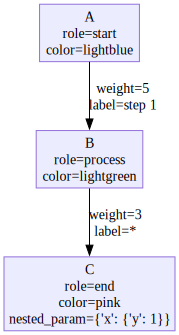

In [ ]:
drawing = draw_nx(G,name=None,engine='dot')
drawing

In [ ]:
drawing = draw_nx(G,name=None,engine='dot',ret_dot=True)
print(drawing.source)

digraph {
	labelloc=t rankdir=TB
	A [label="A
role=start
color=lightblue" color="#9370DB" fillcolor="#ECECFF" shape=box style=filled]
	B [label="B
role=process
color=lightgreen" color="#9370DB" fillcolor="#ECECFF" shape=box style=filled]
	C [label="C
role=end
color=pink
nested_param={'x': {'y': 1}}" color="#9370DB" fillcolor="#ECECFF" shape=box style=filled]
	A -> B [label="weight=5
label=step 1" color=black]
	B -> C [label="weight=3
label=*" color=black]
}



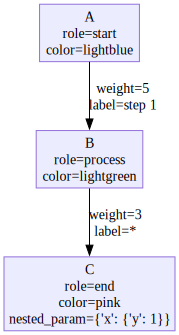

In [ ]:
display_in_ipython(drawing)

In [ ]:
# this is how we tell ipython what to display
drawing._repr_mimebundle_()

{'image/svg+xml': '<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Generated by graphviz version 12.2.1 (20241206.2353)\n -->\n<!-- Pages: 1 -->\n<svg width="179pt" height="335pt"\n viewBox="0.00 0.00 179.25 335.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n<g id="graph0" class="graph" transform="scale(1 1) rotate(0) translate(4 331)">\n<polygon fill="white" stroke="none" points="-4,4 -4,-331 175.25,-331 175.25,4 -4,4"/>\n<!-- A -->\n<g id="node1" class="node">\n<title>A</title>\n<polygon fill="#ececff" stroke="#9370db" points="135.62,-327 35.62,-327 35.62,-269.5 135.62,-269.5 135.62,-327"/>\n<text text-anchor="middle" x="85.62" y="-309.7" font-family="Times,serif" font-size="14.00">A</text>\n<text text-anchor="middle" x="85.62" y="-293.2" font-family="Times,serif" font-size="14.00">role=start</text>\n<text text-anchor="middle" x="85.6

# Export

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()
     